In [1]:
from celcomen.models.celcomen import celcomen
from celcomen.models.simcomen import simcomen
from celcomen.utils.helpers import normalize_g2g, calc_sphex, calc_gex

In [2]:
!pwd

/nfs/team205/sm58/packages/celcomen_trials/celcomen_final


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
from torch_geometric.loader import DataLoader
import scanpy as sc
import torch
import torch_geometric
from sklearn.neighbors import kneighbors_graph

def get_dataset_loaders(h5ad_path: str, sample_id_name: str, n_neighbors: int, verbose: bool):

    adata = sc.read_h5ad(h5ad_path) 

    adata_list = [  adata[adata.obs[sample_id_name]==i] for i in set(adata.obs[sample_id_name])  ]

    data_list = []
    n_neighbors = 6

    for adata in adata_list:
        pos = torch.from_numpy(adata.obsm["spatial"])
        x = torch.from_numpy(adata.X.todense())    # here x is nodes x 33500 -> add filteration here to take "best" 100
        # normalize x 
        norm_factor = torch.pow(x,2).sum(1).reshape(-1,1)
        x = torch.div(x, norm_factor)
        y = torch.Tensor([0])   # here we will store GT value
        #edge_index = knn_graph(pos, k=n_neighbors)
        edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
        edge_index = torch.from_numpy(np.array(np.where(edge_index)))
        data = torch_geometric.data.Data(x=x, pos=pos, y=y, edge_index=edge_index)
        data.validate(raise_on_error=True)    # performs basic checks on the graph
        data_list.append(data)

    loader = DataLoader( data_list, batch_size=1, shuffle=True)

    if verbose:
        for step, data in enumerate(loader):
            print(f'Step {step+1}')
            print("=====")
            print(f'Number of graphs in the current batch: {data.num_graphs}')
            print(data)
            print()

    return loader

In [6]:
h5ad_path="data/visium-OCT_SAN_raw.h5ad"

loader = get_dataset_loaders("data/visium-OCT_SAN_raw.h5ad", "sangerID", 6, True, )

Step 1
=====
Number of graphs in the current batch: 1
DataBatch(x=[4243, 33538], edge_index=[2, 25458], y=[1], pos=[4243, 2], batch=[4243], ptr=[2])

Step 2
=====
Number of graphs in the current batch: 1
DataBatch(x=[3400, 33538], edge_index=[2, 20400], y=[1], pos=[3400, 2], batch=[3400], ptr=[2])

Step 3
=====
Number of graphs in the current batch: 1
DataBatch(x=[3430, 33538], edge_index=[2, 20580], y=[1], pos=[3430, 2], batch=[3430], ptr=[2])

Step 4
=====
Number of graphs in the current batch: 1
DataBatch(x=[3802, 33538], edge_index=[2, 22812], y=[1], pos=[3802, 2], batch=[3802], ptr=[2])

Step 5
=====
Number of graphs in the current batch: 1
DataBatch(x=[2881, 33538], edge_index=[2, 17286], y=[1], pos=[2881, 2], batch=[2881], ptr=[2])

Step 6
=====
Number of graphs in the current batch: 1
DataBatch(x=[3448, 33538], edge_index=[2, 20688], y=[1], pos=[3448, 2], batch=[3448], ptr=[2])

Step 7
=====
Number of graphs in the current batch: 1
DataBatch(x=[3052, 33538], edge_index=[2, 1831

In [16]:
from tqdm import tqdm
import numpy as np
import torch
            
            
def train(num_epochs, learning_rate, model, loader, zmft_scalar=1e-1, seed=1, device="cpu"):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
    losses = []
    model.train()
    torch.manual_seed(seed)
    
    for epoch in range(num_epochs):
        losses_= []

        for data in loader:
            # move data to device
            data = data.to(device)
            # train loader  # Iterate in batches over the training dataset.
            # set the appropriate gex
            model.set_gex(data.x)
            # derive the message as well as the mean field approximation
            msg, msg_intra, log_z_mft = model(data.edge_index, 1)
            # compute the loss and track it
            loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
            if device=="cpu":
                losses_.append(loss.detach().numpy()[0][0])
            else:
                losses_.append(loss.detach().cpu().numpy()[0][0])
            # derive the gradients, update, and clear
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # repeatedly force a normalization
            model.conv1.lin.weight = torch.nn.Parameter(normalize_g2g(model.conv1.lin.weight), requires_grad=True)
            model.lin.weight = torch.nn.Parameter(normalize_g2g(model.lin.weight), requires_grad=True)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
            
        print(f"Loss={np.mean(losses_)}")
        losses.append(np.mean(losses_))

    return losses


In [17]:
torch.cuda.is_available()

True

In [21]:
n_genes=33538
n_neighbors=6
seed=1
zmft_scalar = 5e-2
epochs = 10
learning_rate = 5e-1


model = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
model.to("cuda")
losses = train(epochs, learning_rate, model, loader, zmft_scalar=1e-1, seed=1, device="cuda")

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.19 GiB. GPU 0 has a total capacity of 79.14 GiB of which 1.95 GiB is free. Including non-PyTorch memory, this process has 77.18 GiB memory in use. Of the allocated memory 75.16 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'loss')]

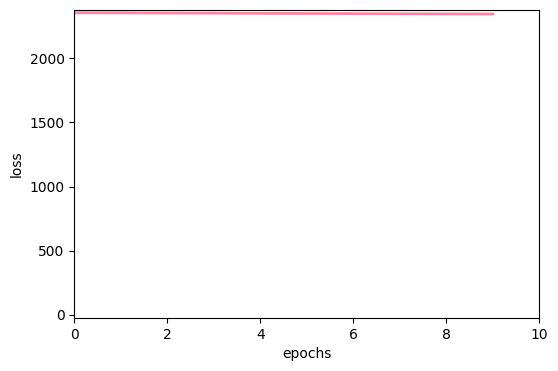

In [14]:
# create the plot
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')

In [13]:
adata = sc.read_h5ad(h5ad_path) 
adata.obs["sangerID"]

spot_id
HCAHeartST10659160_AAACAACGAATAGTTC-1    HCAHeartST10659160
HCAHeartST10659160_AAACAAGTATCTCCCA-1    HCAHeartST10659160
HCAHeartST10659160_AAACAATCTACTAGCA-1    HCAHeartST10659160
HCAHeartST10659160_AAACACCAATAACTGC-1    HCAHeartST10659160
HCAHeartST10659160_AAACAGAGCGACTCCT-1    HCAHeartST10659160
                                                ...        
HCAHeartST13233999_TTGTTCAGTGTGCTAC-1    HCAHeartST13233999
HCAHeartST13233999_TTGTTCTAGATACGCT-1    HCAHeartST13233999
HCAHeartST13233999_TTGTTGTGTGTCAAGA-1    HCAHeartST13233999
HCAHeartST13233999_TTGTTTCCATACAACT-1    HCAHeartST13233999
HCAHeartST13233999_TTGTTTGTGTAAATTC-1    HCAHeartST13233999
Name: sangerID, Length: 27108, dtype: category
Categories (8, object): ['HCAHeartST10659160', 'HCAHeartST12992072', 'HCAHeartST13228105', 'HCAHeartST13228106', 'HCAHeartST13233996', 'HCAHeartST13233997', 'HCAHeartST13233998', 'HCAHeartST13233999']

In [12]:
adata

AnnData object with n_obs × n_vars = 27108 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'annotation_JC', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'region_cell2loc'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL'
    uns: 'spatial'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'